In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [2]:
import pandas as pd
import numpy as np
import re
import string
import random
import missingno
import plotly.express as px
import joblib

# plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


# Download necessary resources for NLP
from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize


# model
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')

In [4]:
def split(location):
    return str(location).split(',')[0]

data['country'] = data.location.apply(split)

# only train and test job postings in US
data = data.loc[data['country']=='US'].copy()

In [5]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

data.fillna(' ', inplace=True)

data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']

In [6]:
data['fraudulent'].value_counts()

fraudulent
0    9926
1     730
Name: count, dtype: int64

In [7]:
data.drop_duplicates(subset='text', inplace=True)

In [8]:
data['fraudulent'].value_counts()

fraudulent
0    9685
1     718
Name: count, dtype: int64

In [9]:
data = data[data['fraudulent'] == 1]

In [10]:
data = data.reset_index()

In [11]:
data.head()

,index,fraudulent,text
0,98,1,"IC&E Technician US, , Stocton, CA ..."
1,173,1,Technician Instrument & Controls US Edison In...
2,215,1,"IC&E Technician Mt Poso US, CA, Bakersfield, C..."
3,357,1,"Financing Auto(car) sales US, IL, hazelcrest L..."
4,493,1,"Admin Assistant/ Receptionist US, CA, Los Ang..."


In [12]:
X_train = data['text']

In [13]:
# pip install googletrans==4.0.0-rc1

In [14]:
# from googletrans import Translator
# from time import sleep

# def back_translation(text, src_lang='en', intermediate_lang=None):
#     # Create a translator object
#     translator = Translator()

#     # If no intermediate language is provided, randomly choose one
#     if intermediate_lang is None:
#         intermediate_langs = ['fr', 'es', 'de', 'ru']#, 'zh-cn']  # List of example languages
#         intermediate_lang = random.choice(intermediate_langs)

#     # Translate to intermediate language
#     intermediate_text = translator.translate(text, src=src_lang, dest=intermediate_lang).text
#     if not intermediate_text:
#         print(text)
#     # Translate back to source language
#     augmented_text = translator.translate(intermediate_text, src=intermediate_lang, dest=src_lang).text

#     return augmented_text

# def augment_dataset(X_train, y_train):
#     augmented_dataset = []
#     X_train_fake = X_train[y_train == 1].reset_index(drop = True)
#     i = 0
#     for fake in X_train_fake:
#         i += 1
#         print(i, len(fake))
#         if len(fake) < 5000:
#             augmented_text = back_translation(fake) #, intermediate_lang='es')
#             sleep(10)
#             augmented_dataset.append(augmented_text)
#         if i%10 == 0:
#             sleep(30)
#     dataset = pd.Series(augmented_dataset)
#     dataset.to_csv('augment_data.csv', index=False)
#     return pd.concat([X_train, dataset]) #, pd.concat([y_train, np.ones(len(augmented_dataset))])

In [15]:
# X_train_new = augment_dataset(X_train, y_train)

In [16]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm') #, disable=['parser', 'tagger', 'ner'])

# Custom tokenizer using spaCy
def spacy_tokenizer(document):
    result = []
    for sent in sent_tokenize(document):
        for token in nlp(sent):
            if not token.is_punct and not token.is_space and not token.is_stop:
                if not token.like_num and not token.like_url:
                    if len(token.text) < 30:
                        result.append(token.lemma_)
    return result


In [17]:
# text = data.iloc[2,2]
# # text = clean_text(text)
# spacy_tokenizer(text)

In [18]:
# creating our bag of words
# bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer,
                               lowercase=True,
                               max_df=0.5,
                               min_df=2,
                               ngram_range=(1, 2)
                               )


# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # remove any symbols    
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    # Removing spaces and converting text into lowercase
    return text.strip().lower()


In [19]:
data_pipeline =  Pipeline([("cleaner", predictors()),
                           ('vectorizer', tfidf_vector),
                          ])

In [20]:
vect_text = data_pipeline.fit_transform(X_train)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
vect_text.shape

(718, 25597)

## LSA

In [22]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [23]:
# most important words for each topic
vocab = data_pipeline.named_steps["vectorizer"].get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")
         

Topic 0: 
home entry start datum amp need datum entry project internet product 

Topic 1: 
start entry home internet typing comfort home home typing position available earn comfort 

Topic 2: 
amp cruise free board english speaker luxury tax free ultra ultra luxury speaker 

Topic 3: 
work home able home accessquiet accessquiet work area away away distractionsmust distractionsmust distractionsmust able figure salary 

Topic 4: 
financing medium size size business small medium cruise free medium credit size financing product 

Topic 5: 
contract financing accept online application onlyclick onlyclick onlyclick apply online application agreement accept e mail 

Topic 6: 
gary hoa pay estate real estate money real candidate community property 

Topic 7: 
money make money perfect dollar make pay money make save money boss ability rise 

Topic 8: 
property gary hoa estate real estate winterization real community cartwright rental hoa 

Topic 9: 
winterization perform secure repair response 

## LDA

In [24]:
# n_components is the number of topics
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 

lda_top=lda_model.fit_transform(vect_text)

In [25]:
# most important words for each topic
vocab = data_pipeline.named_steps["vectorizer"].get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
mso church project mso style style false para margin cell cell phone size 

Topic 1: 
amp cruise free board english speaker ultra luxury tax free ultra luxury speaker 

Topic 2: 
datum design information customer account subsea technical assignedable industry datum entry knowledge 

Topic 3: 
american secure secure benefit american secure gary investment company benefit benefit operate gary cartwright investment 

Topic 4: 
affair lean local environmental program local government datum strategy government employee assistance 

Topic 5: 
receptionist caller sap telephone entry receptionist manager meet aecom ensure performance assign 

Topic 6: 
project amp team product customer service include engineering system administrative ability 

Topic 7: 
home start entry internet earn datum entry money work home datum typing 

Topic 8: 
financing business size business help medium size small medium sale credit size medium 

Topic 9: 
different ohio ve corporation cincinnati quality s

In [26]:
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
 

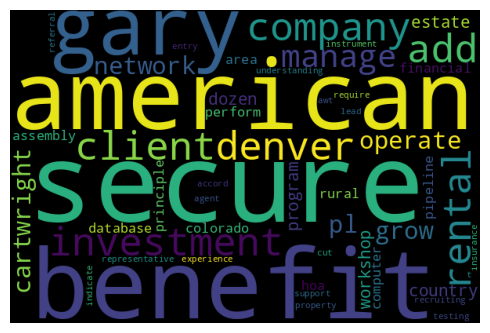

In [27]:
draw_word_cloud(3)

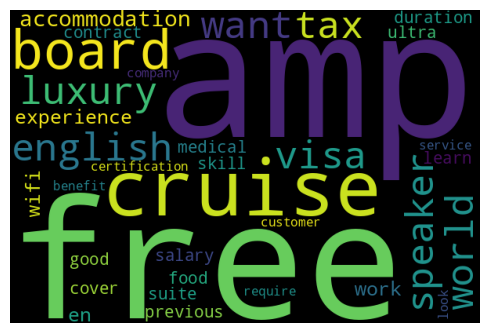

In [28]:
draw_word_cloud(1)

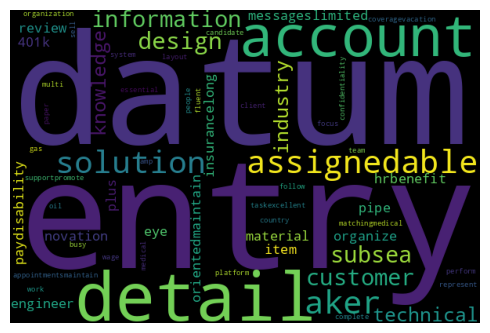

In [29]:
draw_word_cloud(2)

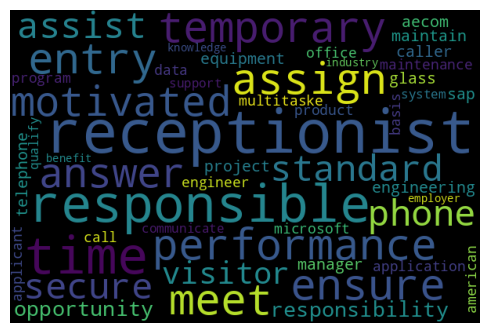

In [30]:
draw_word_cloud(5)

## BERTOPIC

In [31]:
import re
import string

import nltk

In [32]:
!pip install bertopic
from bertopic import BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 6.5 MB/s eta 0:00:00
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=4eda157f74c6bdc75dc842f989702d1b665e684107f6737fb6bdf4fdcc572ca0
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython


2024-03-09 01:11:40.817030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 01:11:40.817189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 01:11:40.996877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [33]:
# Basic Text preprocessing 
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    # convert to lower case
    text = str(text).lower()
    
    # remove urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # removes newline characters
    text = re.sub('\n', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    return text

data['text'] = data['text'].apply(lambda x:clean_text(x))

In [34]:
fake_job_docs = data['text'].to_list()

In [35]:
from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
fake_job_docs_model= BERTopic(ctfidf_model=ctfidf_model, language="english").fit(fake_job_docs)

fake_job_docs_topics, fake_job_docs_probabilities = fake_job_docs_model.fit_transform(fake_job_docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [36]:
fake_job_docs_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,94,-1_phone_product_networking_sales,"[phone, product, networking, sales, is, are, a...",[director of engineering hma security products...
1,0,102,0_gas_oil_solutions_engineering,"[gas, oil, solutions, engineering, subsea, des...",[project subcontracting manager us tx houston ...
2,1,60,1_administrative_assistant_office_church,"[administrative, assistant, office, church, du...",[admin assistant us md baltimore ...
3,2,50,2_accion_customer_service_call,"[accion, customer, service, call, story, cente...",[warehouse associate us tx austin the accion ...
4,3,49,3_aptitude_recruiting_new_product,"[aptitude, recruiting, new, product, bonus, st...",[director of technical operations us ny ny an...
5,4,46,4_technician_refined_equipment_plant,"[technician, refined, equipment, plant, resour...",[ice technician us stocton ca ...
6,5,44,5_financing_medium_small_size,"[financing, medium, small, size, those, credit...",[agency sales managers us ny chautauqua we ha...
7,6,32,6_you_money_internet_earn,"[you, money, internet, earn, get, can, home, s...",[payroll data coordinator positions earn dai...
8,7,24,7_accessquiet_distractionsmust_suppliescompute...,"[accessquiet, distractionsmust, suppliescomput...",[receptionist data entry office support us m...
9,8,23,8_payroll_clerk_patient_claims,"[payroll, clerk, patient, claims, reports, acc...",[payroll clerk us ga columbus at dyncorp inter...


In [37]:
fake_job_docs_model.visualize_barchart(top_n_topics = 16, n_words = 10).show()